# 주식 예측에 도전해 보자
Yahoo Finance : https://finance.yahoo.com/?guccounter=1 데이터셋 다운로드  
  
## (1) 삼성전자 주식 시세 예측
### 1.  시계열 데이터 준비

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

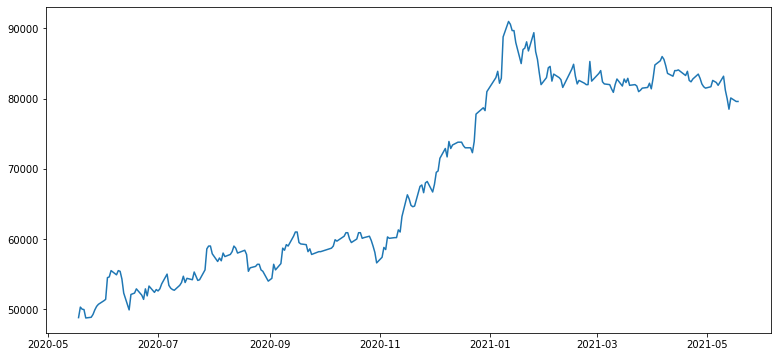

In [48]:
#시계열 안정성의 정성적 분석
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [49]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

### 2. 각종 전처리 수행

In [50]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [51]:
# 로그 변환
ts_log = np.log(ts)

### 3. 시계열 안정성 분석

In [52]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

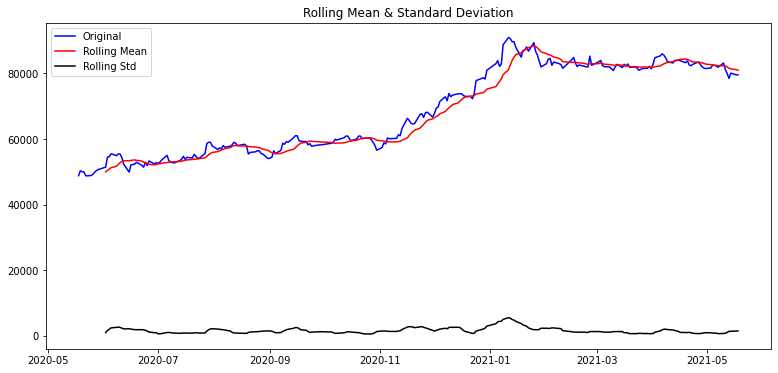

In [53]:
plot_rolling_statistics(ts, window=12)

In [54]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [55]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


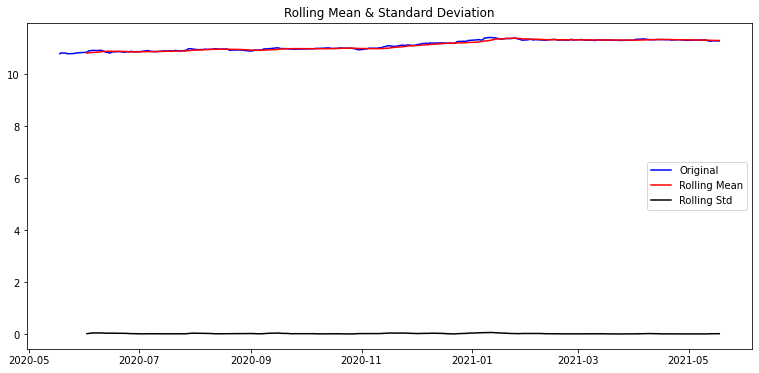

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


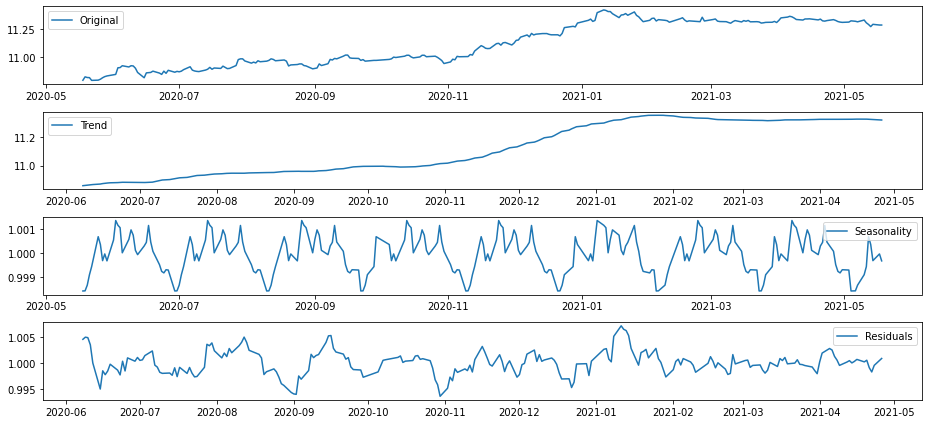

In [56]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [57]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### 4. 학습, 테스트 데이터셋 생성

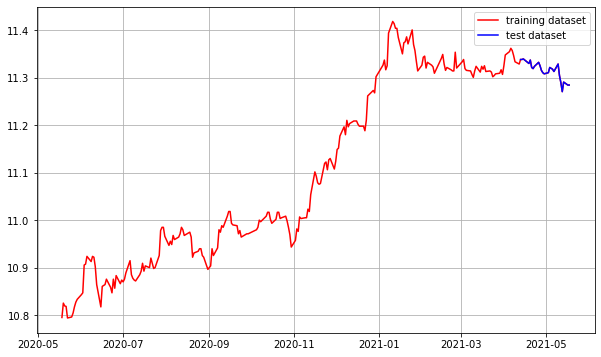

In [58]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기

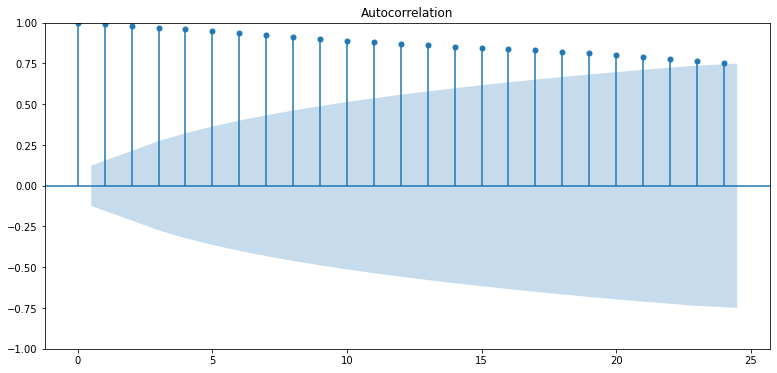

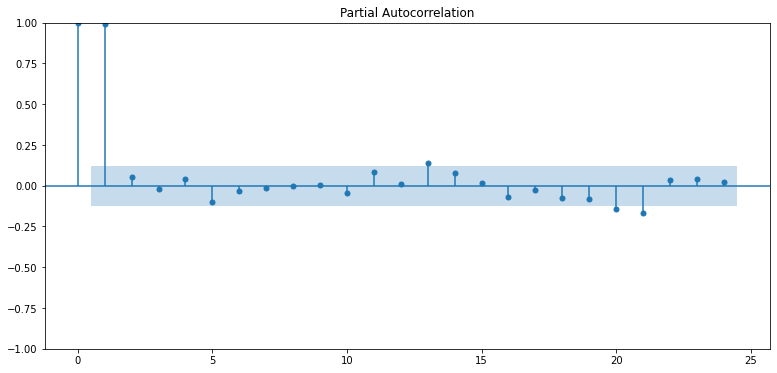

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


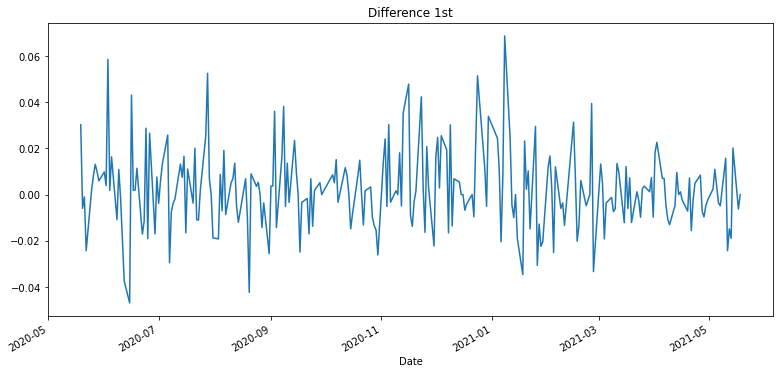

In [60]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


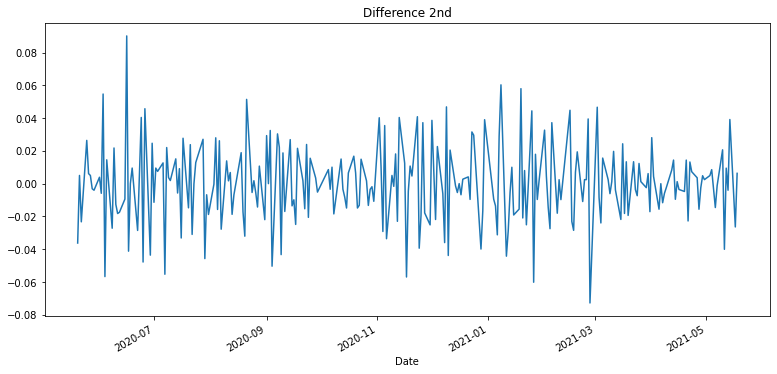

In [61]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 6. ARIMA 모델 훈련과 테스트

In [66]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 583.363
Date:                Thu, 17 Feb 2022   AIC                          -1164.726
Time:                        03:23:19   BIC                          -1161.314
Sample:                             0   HQIC                         -1163.349
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.33e-05     13.751      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                22.25
Prob(Q):                              0.80   Pr

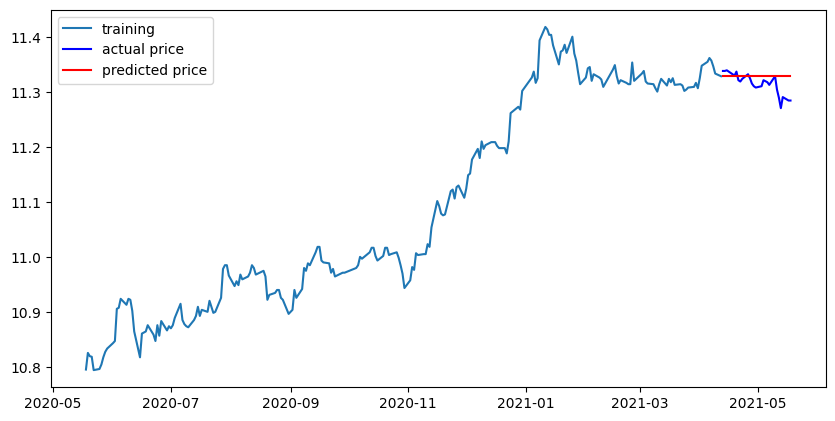

In [67]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3509600.000000066
MAE:  1408.0000000000023
RMSE:  1873.3926443754567
MAPE: 1.74%


#### 삼성전자 : MAPE가 1.74%로 높은 정확도로 예측되었다.

### 7. 다른 주식 종목 예측해 보기
---

## (2) 테슬라 주가 시세 예측
### 1. 시계열 데이터 준비

In [69]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    798.150024
2021-02-18    787.380005
2021-02-19    781.299988
2021-02-22    714.500000
2021-02-23    698.840027
Name: Close, dtype: float64

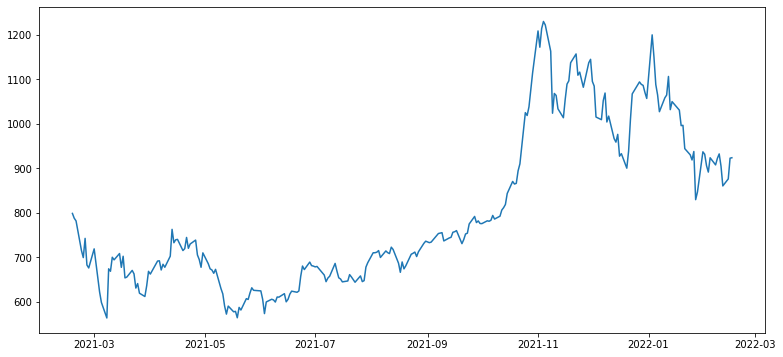

In [70]:
#시계열 안정성의 정성적 분석
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [71]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

### 2. 각종 전처리 수행

In [72]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [73]:
# 로그 변환
ts_log = np.log(ts)

### 3. 시계열 안정성 분석

In [74]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

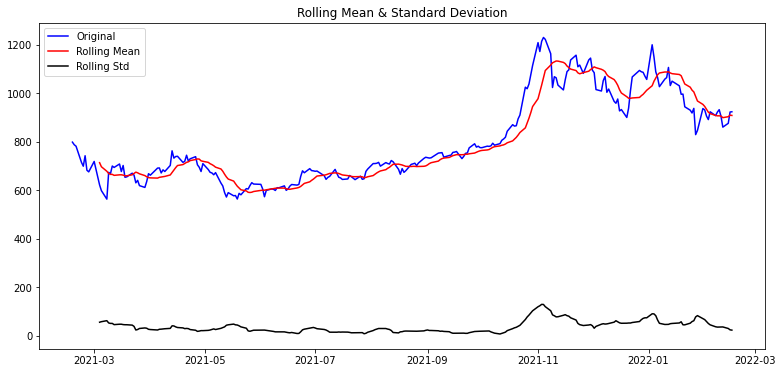

In [75]:
plot_rolling_statistics(ts, window=12)

In [76]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [77]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.319322
p-value                          0.620287
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


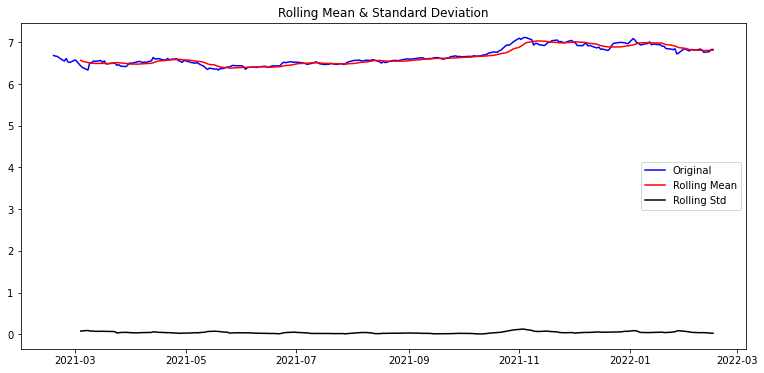

Results of Dickey-Fuller Test:
Test Statistic                  -1.253137
p-value                          0.650330
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


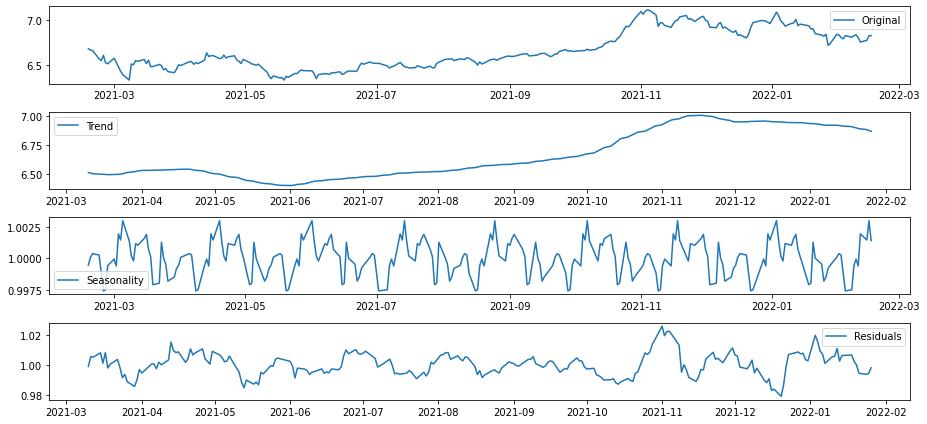

In [78]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [79]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.567501e+00
p-value                        8.089813e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


### 4. 학습, 테스트 데이터셋 생성

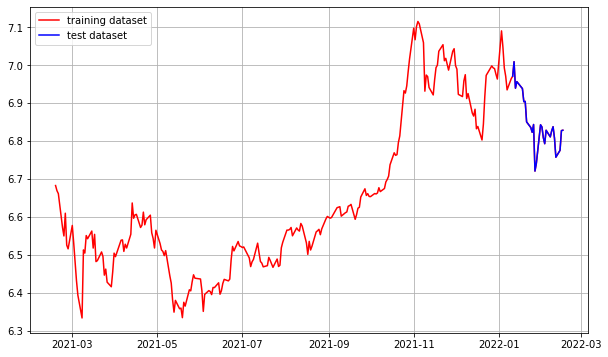

In [81]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기

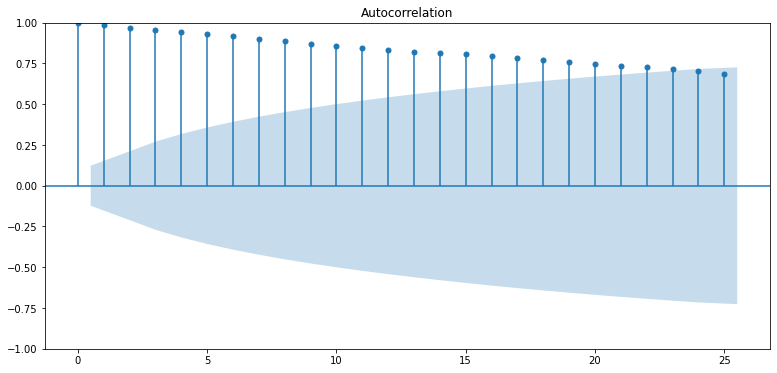

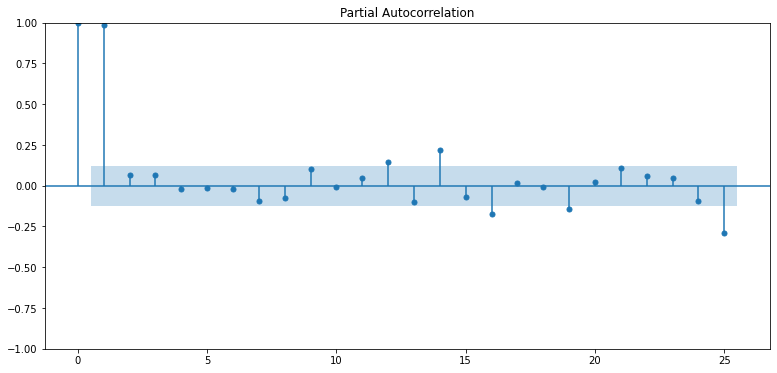

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.683248e+01
p-value                        1.155026e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


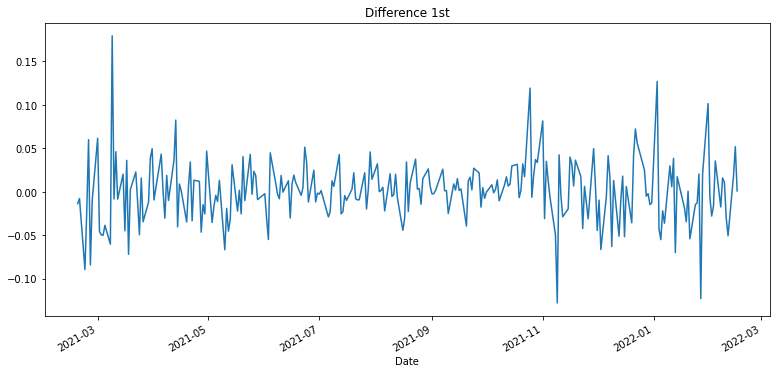

In [83]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.198159e+00
p-value                        2.404162e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


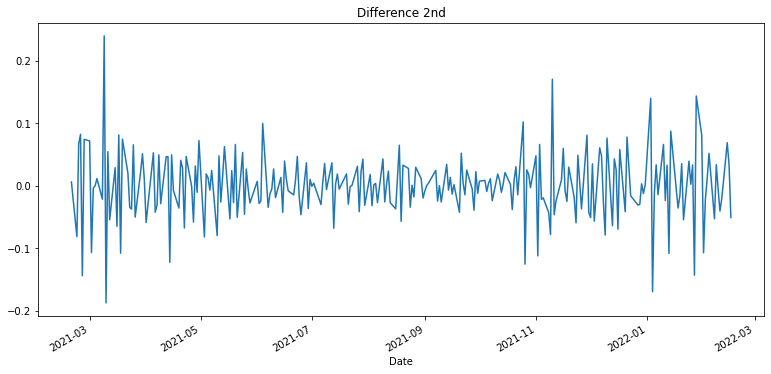

In [84]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [85]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 438.744
Date:                Thu, 17 Feb 2022   AIC                           -875.488
Time:                        03:23:49   BIC                           -872.063
Sample:                             0   HQIC                          -874.106
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   6.74e-05     18.190      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):               145.55
Prob(Q):                              0.41   Pr

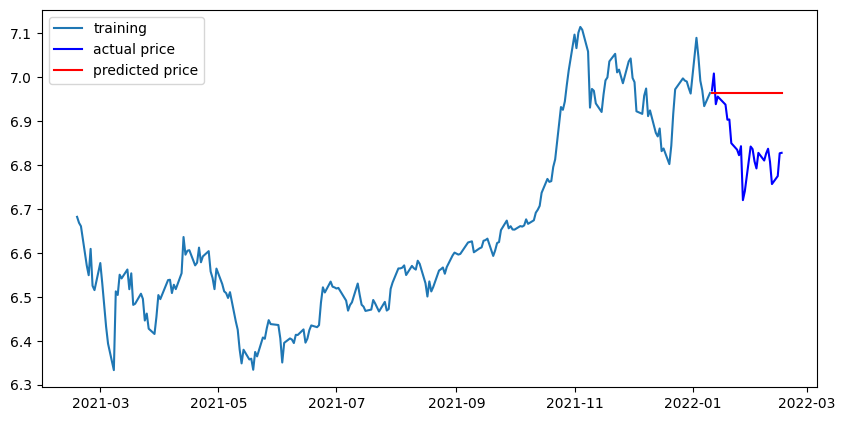

In [86]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  17785.63894096211
MAE:  119.42076211538476
RMSE:  133.36280943712197
MAPE: 13.15%


#### 테슬라 : MAPE가 13.15%로 낮은 정확도로 예측되었다.

## (3) SK하이닉스 주가 시세 예측
### 1. 시계열 데이터 준비

In [88]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/000660.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    130000.0
2021-02-18    126000.0
2021-02-19    133000.0
2021-02-22    136500.0
2021-02-23    138500.0
Name: Close, dtype: float64

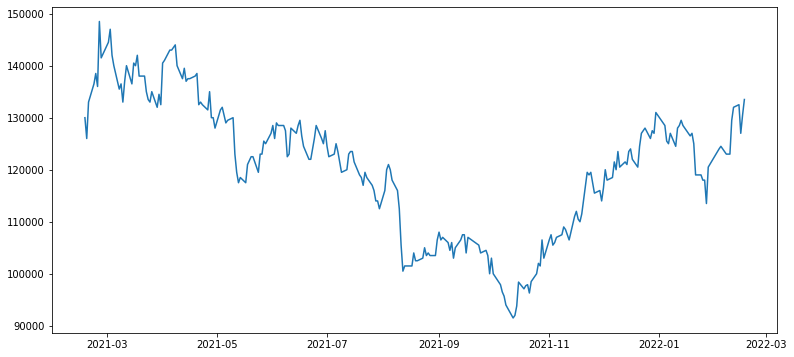

In [89]:
#시계열 안정성의 정성적 분석
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [90]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

### 2. 각종 전처리 수행

In [91]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [92]:
# 로그 변환
ts_log = np.log(ts)

### 3. 시계열 안정성 분석

In [93]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

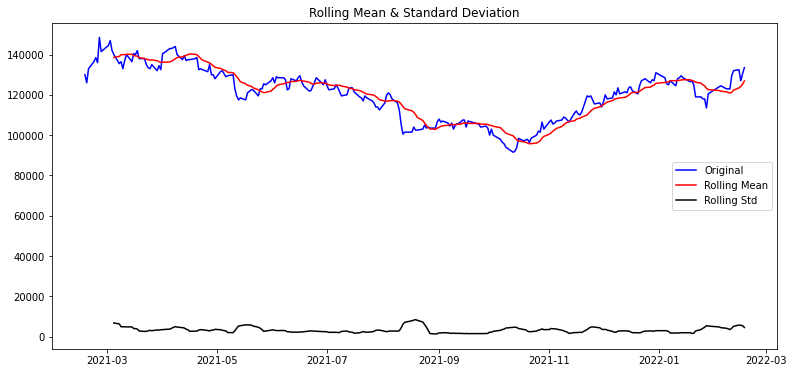

In [94]:
plot_rolling_statistics(ts, window=12)

In [95]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [96]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.606365
p-value                          0.480395
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


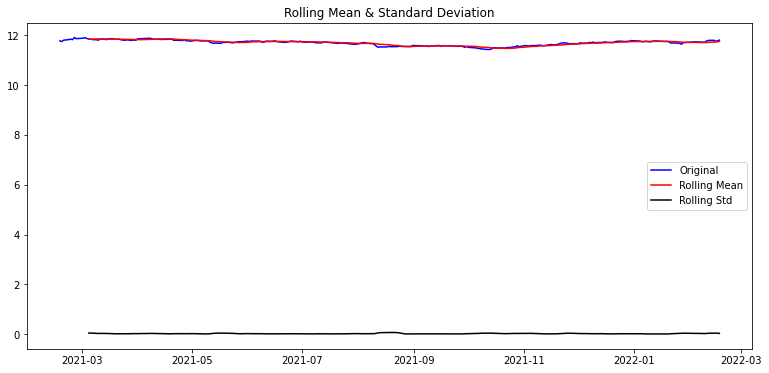

Results of Dickey-Fuller Test:
Test Statistic                  -1.546207
p-value                          0.510543
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


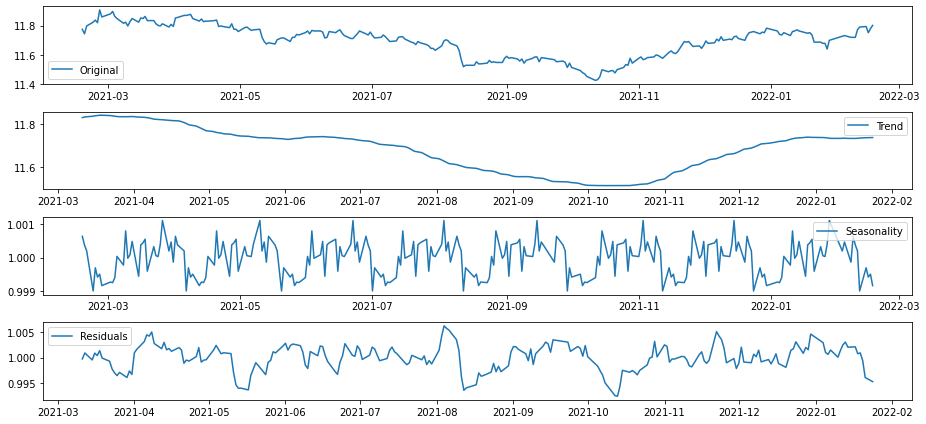

In [97]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [98]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.508960
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


### 4. 학습, 테스트 데이터셋 생성

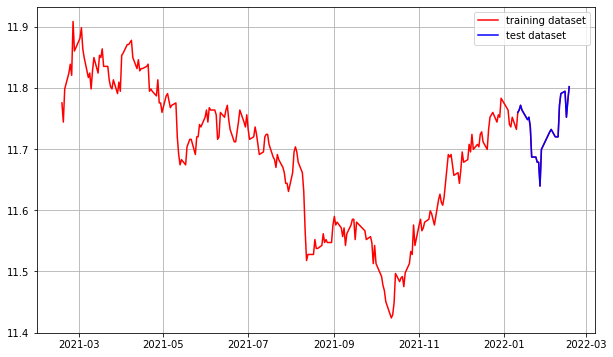

In [99]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기

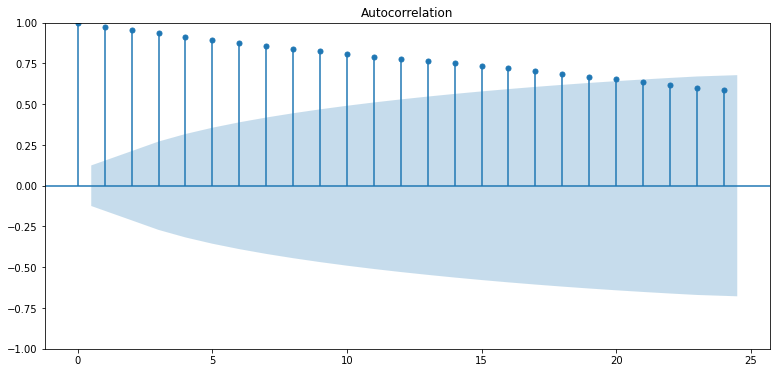

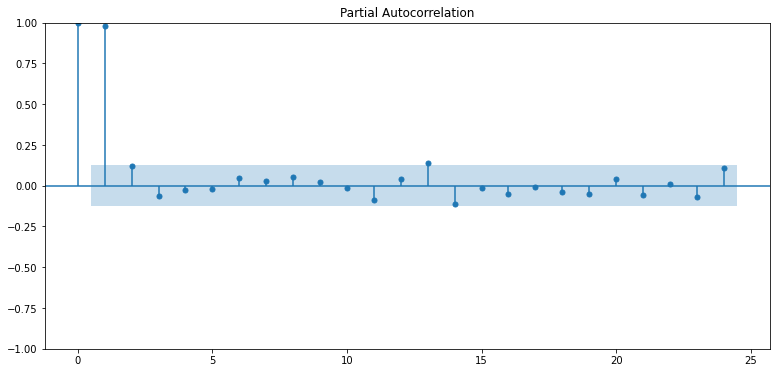

In [100]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.704722e+01
p-value                        8.117643e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


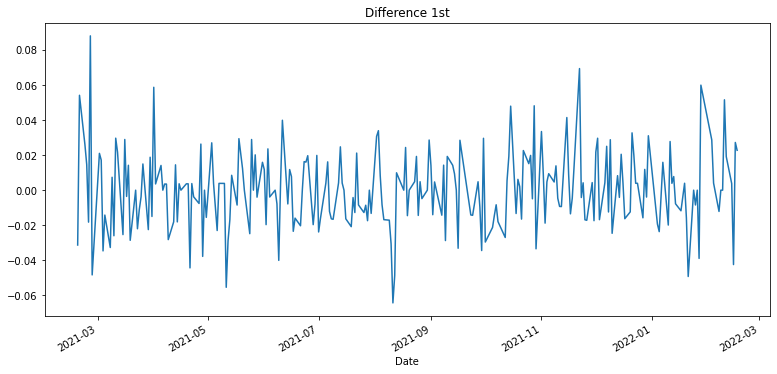

In [101]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.479256e+00
p-value                        1.407658e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


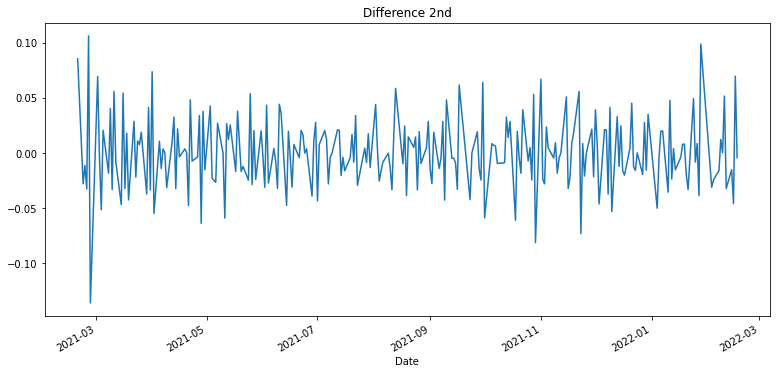

In [104]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [105]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  223
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 537.435
Date:                Thu, 17 Feb 2022   AIC                          -1068.871
Time:                        03:39:51   BIC                          -1058.649
Sample:                             0   HQIC                         -1064.744
                                - 223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.7095      0.065    179.554      0.000      11.582      11.837
ar.L1          0.9788      0.012     78.418      0.000       0.954       1.003
sigma2         0.0005   3.57e-05     13.026      0.0

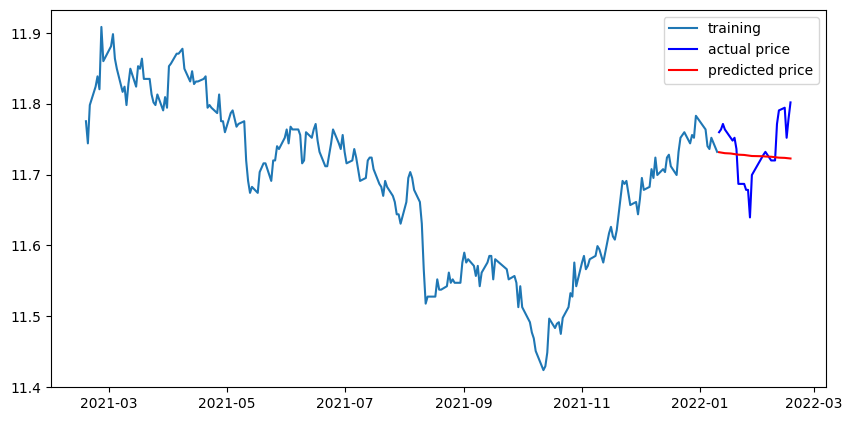

In [106]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  27671485.37273468
MAE:  4347.37197361667
RMSE:  5260.369319043548
MAPE: 3.47%


#### SK하이닉스 : MAPE가 3.47%로 꽤 높은 정확도로 예측되었다.

## (4) 아마존 주가 시세 예측
### 1. 시계열 데이터 준비

In [108]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMZN.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2021-02-17    3308.639893
2021-02-18    3328.229980
2021-02-19    3249.899902
2021-02-22    3180.739990
2021-02-23    3194.500000
Name: Close, dtype: float64

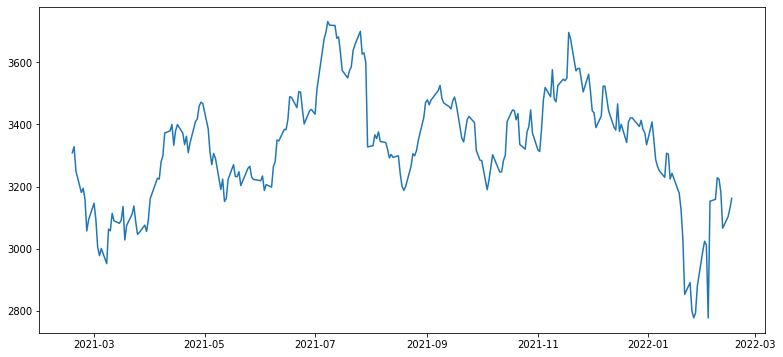

In [109]:
#시계열 안정성의 정성적 분석
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [110]:
ts[ts.isna()]  # 시계열(Time Series)에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

### 2. 각종 전처리 수행

In [111]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [112]:
# 로그 변환
ts_log = np.log(ts)

### 3. 시계열 안정성 분석

In [121]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

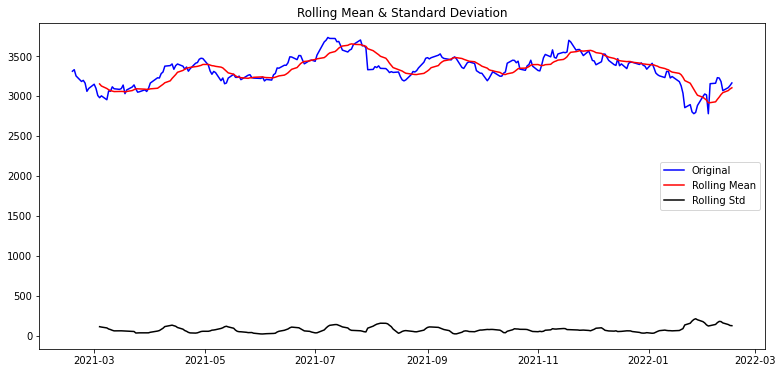

In [122]:
plot_rolling_statistics(ts, window=12)

In [123]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [124]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.502685
p-value                          0.114822
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


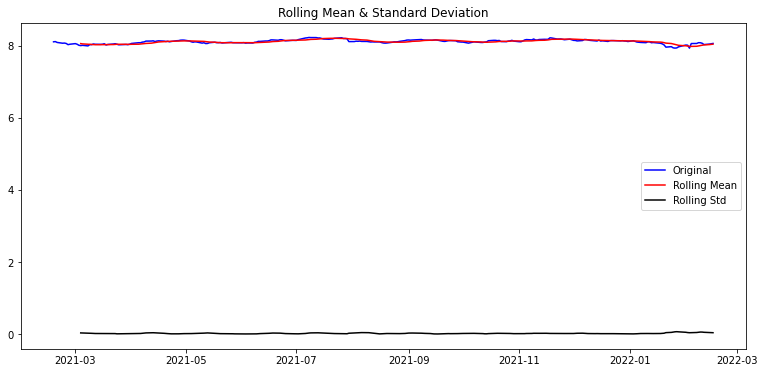

Results of Dickey-Fuller Test:
Test Statistic                  -2.563007
p-value                          0.100886
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64


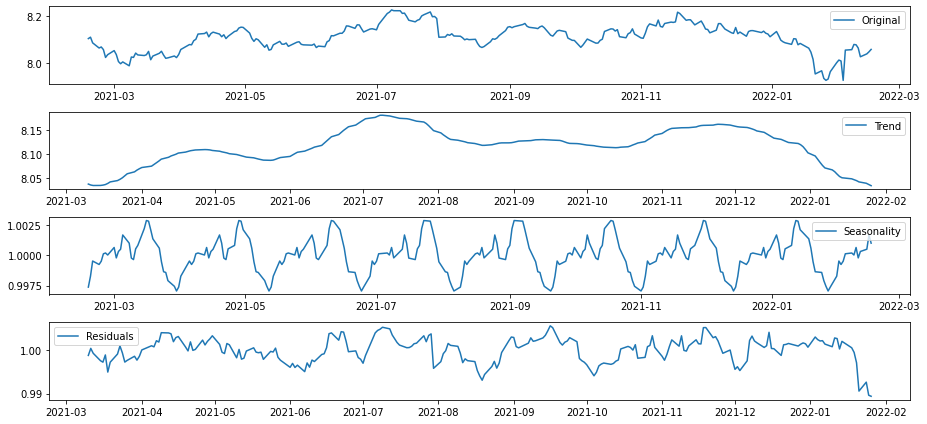

In [125]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [126]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -3.879279
p-value                          0.002193
#Lags Used                       0.000000
Number of Observations Used    223.000000
Critical Value (1%)             -3.460019
Critical Value (5%)             -2.874590
Critical Value (10%)            -2.573725
dtype: float64


### 4. 학습, 테스트 데이터셋 생성

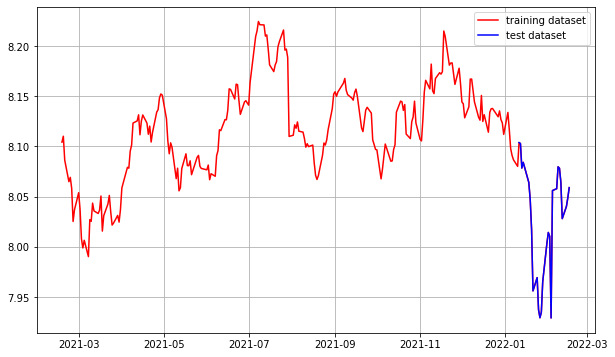

In [127]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기

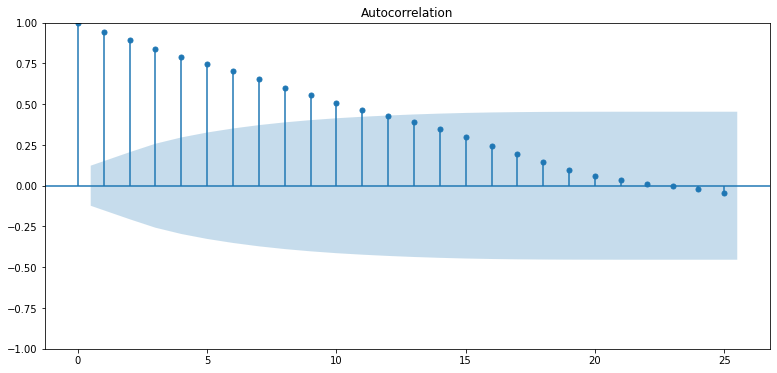

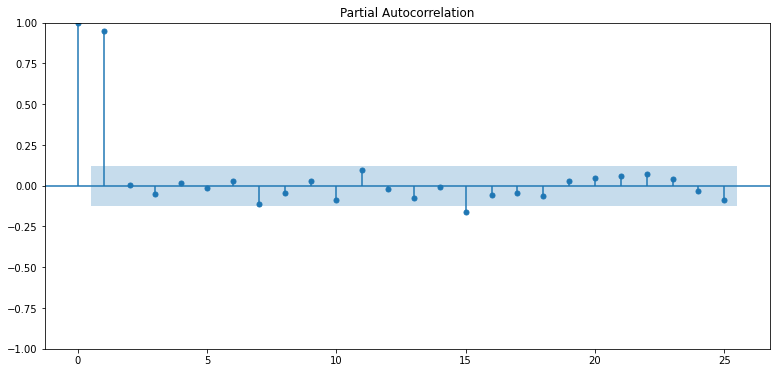

In [128]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.642878e+01
p-value                        2.489977e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


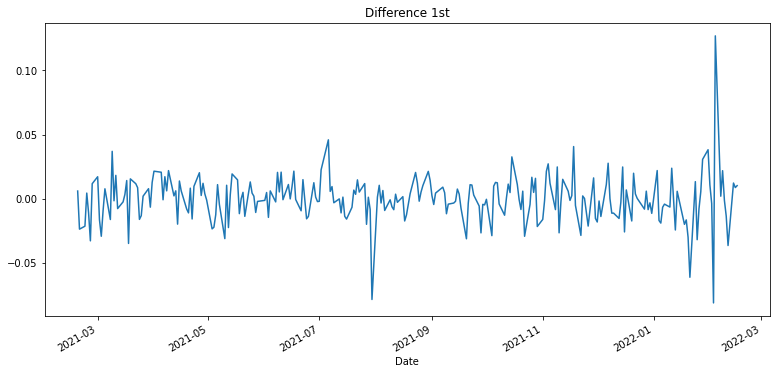

In [129]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.170969e+00
p-value                        8.625002e-13
#Lags Used                     1.200000e+01
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


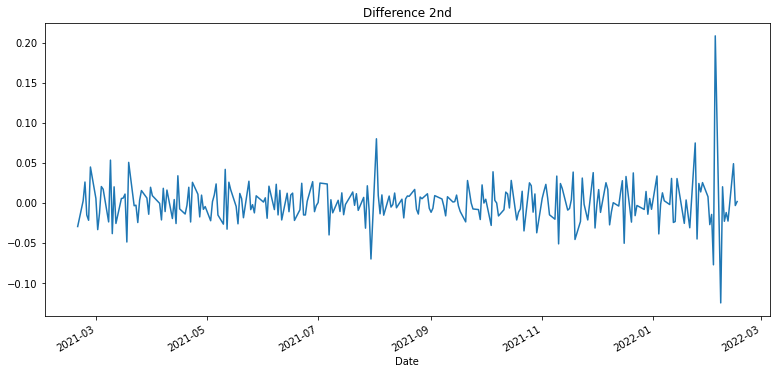

In [130]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [132]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 635.634
Date:                Thu, 17 Feb 2022   AIC                          -1265.269
Time:                        03:46:31   BIC                          -1254.981
Sample:                             0   HQIC                         -1261.118
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1136      0.021    377.919      0.000       8.071       8.156
ar.L1          0.9526      0.019     51.048      0.000       0.916       0.989
sigma2         0.0002   1.41e-05     15.597      0.0

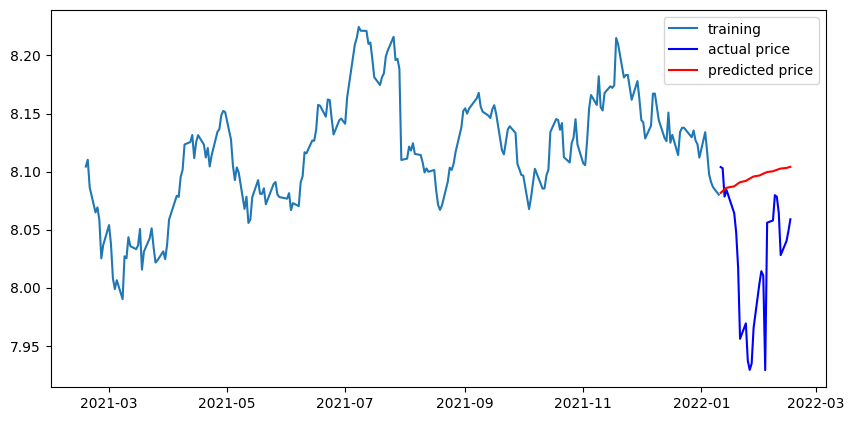

In [133]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [134]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  75748.54315269098
MAE:  226.4988268584708
RMSE:  275.2245322508351
MAPE: 7.70%


#### 아마존 : MAPE가 7.7%로 그저 그런 정확도로 예측되었다.

## EXPLORATION 11 회고
#### 주식 종목 예측 비교  
- 삼성전자 1.74% MAPE 도출  
- 테슬라 13.15% MAPE 도출  
- SK하이닉스 3.47% MAPE 도출  
- 아마존 7.7% MAPE 도출  
  
모든 종목이 **MAPE 15% 미만의 정확도로 예측**되었다.  

삼성전자 주식 예측 결과가 가장 높은 정확도를 보였다. 1.74%의 오차율은 생각보다 유의미한 지표라고 생각했지만, SK하이닉스와 아마존 특히 테슬라는 오차율이 높아 실용적으로 주가 예측에 사용하기는 힘들 것 같다. 신기한건 삼성전자와 SK하이닉스의 예측 정확도가 높은 편인데 국내주가 해외주보다 예측 정확도가 높게 도출된게 우연인지, 국내주가 해외주보다 안정성이 있는지 문득 궁금해졌다. 주가의 안정성이 높으면 오차율이 낮을 것이라 생각해서 우량주들로만 선정했는데 우량주가 아닌 단타 위주의 변화 폭이 큰 주가 데이터들을 예측하면 어느정도의 예측 정확도가 나올지 궁금하다.    
  
ARIMA 모델을 빌드하고 훈련 할 때 model = ARIMA(train_data, order=(2, 0, 1)) 로 처음 설정되어있었고, p,d,q를 2,0,1 그대로 수행하니 오류가 나며 MAPE가 낮은 정확도로 예측되어 모수에 대해 조사했다. 위 부분을 해결하기 위해서는 **그리드 서치를 통해 AIC수치가 가장 낮은 값으로 설정하여 모수를 선택**해야한다는 것을 알 수 있었다. 모수 도출 함수는 my_auto_arima(lu_train, [p,d,q])를 사용하여 가장 낮은 값을 모수로 선정했다. 
  
모수 설정에 따라 MAPE 정확도가 달라져 가장 최적의 모수를 찾아 예측 모델을 만들어 정확도를 측정하였다. 정확도가 15% 이상이 나와 모수 변경에 따라 값이 줄어들어 모수에 대한 개념과 ARIMA에 대한 이론적 개념이 많이 필요했다. 아직 개념정립이 부족해 다음에 또 시계열 프로젝트를 수행한다고 해도 수월하게 할 수 있을지는 모르겠다. 개인적으로 통계적 지식이 매우 부족함을 느껴서 이론적 정립이 필요하다 느꼈다. 그래도 시계열 데이터를 가지고 주가 예측을 하는 프로젝트는 흥미로웠고, 평소 내가 관심있는 주식 종목들을 분석해보는 경험이 새로웠다. 조금 더 오차율을 줄인다면 실제로 실생활에 활용하고 싶다 :)  
  
---
2022-02-17